# ***Método de Boosting.***

## ***Universidad Central***

## ***Maestría en analítica de datos***

## ***Métodos estadísticos para analítica de datos.***
## ***Docente: Luis Andrés Campos Maldonado.***

In [1]:
### Paquetes a usar.
import pandas                   as pd
import numpy                    as np
import matplotlib.pyplot        as plt
import seaborn                  as sns
import statsmodels.formula.api  as smf
import warnings
##
from sklearn.model_selection    import train_test_split
from graphviz                   import Source
from sklearn.model_selection    import GridSearchCV, RandomizedSearchCV
from sklearn.metrics            import r2_score
##
from sklearn.linear_model       import LinearRegression
from sklearn.tree               import DecisionTreeRegressor, export_graphviz
from sklearn.ensemble           import RandomForestRegressor
from sklearn.ensemble           import GradientBoostingRegressor, AdaBoostRegressor
from lightgbm                   import LGBMRegressor
import xgboost
##
%matplotlib inline
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (15,6)
warnings.filterwarnings("ignore")
url_base = "https://raw.githubusercontent.com/lacamposm/Metodos_Estadisticos/main/data/"

## _**[DecisionTreeRegressor](https://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html)**_

### ***Predicción de una valor continuo.***

Predecir un valor continuo (también denominado regresión) con un árbol sigue la misma lógica y procedimiento que en una clasificación binaria, excepto que la impureza se mide por desviaciones al cuadrado de la media (errores cuadráticos) en cada subpartición, y el rendimiento predictivo se juzga por
la raíz cuadrada del error cuadrático medio (RMSE) en cada partición. scikit-learn tiene el método [`sklearn.tree.DecisionTreeRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) para entrenar un modelo de regresión del árbol de decisión.

Cómo se usan los árboles uno de los grandes obstáculos que se enfrenta es la naturaleza percibida de "caja negra" de los métodos que utilizan.

En este sentido, el modelo de Decision Tree tiene dos
aspectos atractivos:

• Los Decision Tree proporcionan una herramienta visual para explorar los datos, para tener una idea de que variables son importantes y cómo se relacionan entre sí. Los árboles pueden capturar relaciones no lineales entre variables predictoras.

• Los Decision Tree proporcionan un conjunto de reglas que se pueden comunicar de manera efectiva a
especialistas, ya sea para la implementación o para "vender" un proyecto de minería de datos.

Sin embargo, cuando se trata de predicción, aprovechar los resultados de múltiples árboles es típicamente más poderoso que usar un solo árbol. En particular, _Random Forrest_ potenciado casi siempre brindan una precisión predictiva superior y rendimiento, pero se pierden las mencionadas ventajas de un solo árbol.

***Ideas importantes:***


1. Los Decision Tree producen un conjunto de reglas para clasificar o predecir un resultado.

2. Las reglas corresponden a particiones sucesivas de los datos en subparticiones.

3. Cada partición, o división, hace referencia a un valor específico de una variable predictora y
divide los datos en registros donde el valor del predictor está por encima o por debajo de ese
valor dividido.

4. En cada etapa, el algoritmo de Decision Tree seleciona la división que minimiza el resultado de 
impureza dentro de cada subpartición.

5. La asisganción de la predicción se realiza siguiendo el camino que el árbol va indicando.

6. Un árbol completamente desarrollado sobreajusta (_overfitting_) los datos y debe ser podado para que capturevseñal y no ruido.

7. Los algoritmos como los _Random Forrest_ y árboles potenciados (_boosting_), ofrecen un mejor rendimiento predictivo, pero pierden el poder comunicativo basado en reglas de los algoritmos de Decision Tree.

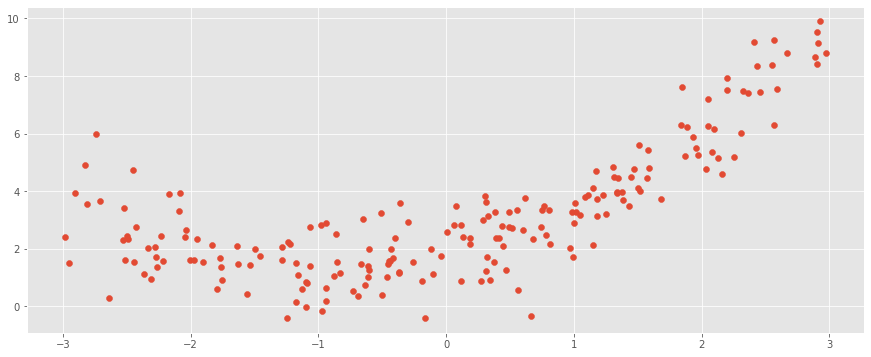

In [2]:
## Simulemos unos datos con relación cuadrática.
np.random.seed(123)
m = 200
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)
plt.scatter(X,y);

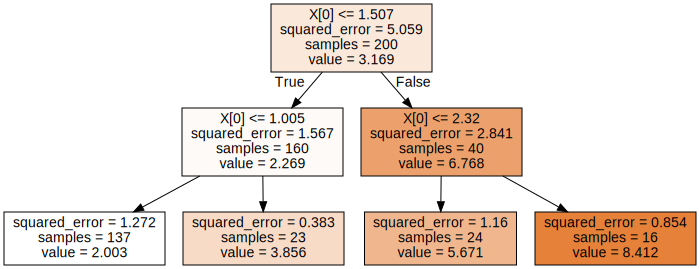

In [3]:
tree_reg = DecisionTreeRegressor(max_depth=2, random_state=123)
tree_reg.fit(X, y)
##
dot_data = export_graphviz(tree_reg, filled=True,)
Source(dot_data, format="png")

Este árbol se parece mucho al árbol de clasificación que ya conocemos. La principal diferencia es que en lugar de predecir una clase en cada nodo, predice un valor. Como ejemplo, supongamos que deseamos hacer una predicción para $x_0=2.15$, luego se debe atravezar el árbol comenzando en la raíz, y finalmente llegando al nodo hoja y el `value` que se predice es 5.671. Esta predicción es simplemente el valor objetivo promedio de la variable target en 24 registros del set de train que quedarón allí. Además esta predicción da como media del error (MSE) (`squared_error`) 1.16 sobre estos 24 registros.

El algoritmo CART funciona casi de la misma manera que antes, excepto que en lugar de tratar de dividir el set de train de una manera que minimice la impureza, ahora trata de dividir el set de train de una manera que minimice el MSE. La función de costo que el algoritmo intenta minimizar es:

$$J(k,t_k)=\frac{m_{left}}{m}MSE_{left}+\frac{m_{right}}{m}MSE_{rigth}$$

Donde:

1. $MSE_{node}=\displaystyle\sum_{i\in\ \ node}(\hat{y}_{node}-y^{(i)})^{2}$

2. $\hat{y}_{node}=\frac{1}{m_{node_i}}\displaystyle\sum_{i \in \ \ node}y^{(i)}$


Al igual que para las tareas de clasificación, los árboles de decisión tienden a tener `overfitting` cuando se trata con tareas de regresión. Sin ninguna regularización (es decir, utilizando el valor predeterminado hiperparámetros), es bastante probable que su algoritmo este con `overfitting`.

***Nota.***

Los árboles priorizan los límites de decisión ortogonales (todas las divisiones son perpendiculares a un eje), esto los hace sensibles a la rotación del set de train. Una forma de limitar problemas que cortes innecesarios (piense en rotar un región en 45 grados)
es usar PCA, que a menudo resulta en una mejor orientación en el set de train.

## ***Ejemplo 1.***

In [4]:
## Importamos el DataSet.
df = pd.read_csv(url_base + 'kc_house_data.csv',)
df.head()

id             date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  20141013T000000  221900.0         3       1.00         1180   
1  6414100192  20141209T000000  538000.0         3       2.25         2570   
2  5631500400  20150225T000000  180000.0         2       1.00          770   
3  2487200875  20141209T000000  604000.0         4       3.00         1960   
4  1954400510  20150218T000000  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      5650     1.0           0     0  ...      7        1180              0   
1      7242     2.0           0     0  ...      7        2170            400   
2     10000     1.0           0     0  ...      6         770              0   
3      5000     1.0           0     0  ...      7        1050            910   
4      8080     1.0           0     0  ...      8        1680              0   

   yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
0      1955             0    98178  47.5112 -122.257           1340   
1      1951          1991    98125  47.7210 -122.319           1690   
2      1933             0    98028  47.7379 -122.233           2720   
3      1965             0    98136  47.5208 -122.393           1360   
4      1987             0    98074  47.6168 -122.045           1800   

   sqft_lot15  
0        5650  
1        7639  
2        8062  
3        5000  
4        7503  

[5 rows x 21 columns]

In [5]:
## Prepocesamiento de la Data.
df_to_model = df.copy()
df_to_model = df_to_model.drop(columns=['id','sqft_living15','sqft_lot15','date'])
df_to_model['renovated'] = df_to_model['yr_renovated'] > 0
df_to_model.drop(columns=['yr_renovated'], inplace=True)
features_categoric = ['waterfront', 'zipcode', 'view']
for column in features_categoric:
    df_to_model[column] = df_to_model[column].astype('category')
df_to_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   price          21613 non-null  float64 
 1   bedrooms       21613 non-null  int64   
 2   bathrooms      21613 non-null  float64 
 3   sqft_living    21613 non-null  int64   
 4   sqft_lot       21613 non-null  int64   
 5   floors         21613 non-null  float64 
 6   waterfront     21613 non-null  category
 7   view           21613 non-null  category
 8   condition      21613 non-null  int64   
 9   grade          21613 non-null  int64   
 10  sqft_above     21613 non-null  int64   
 11  sqft_basement  21613 non-null  int64   
 12  yr_built       21613 non-null  int64   
 13  zipcode        21613 non-null  category
 14  lat            21613 non-null  float64 
 15  long           21613 non-null  float64 
 16  renovated      21613 non-null  bool    
dtypes: bool(1), category(3), float6

In [6]:
# Definimos variable objetivo y predictores. Tomamos además set de train y set de test.
X = df_to_model.drop(columns=['price'])
y = df_to_model['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

### ***Modelo de regresión múltiple.***

In [7]:
## Misma construcción del modelo de una lectura anterior.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
X_train_ml, y_train_ml = X_train.copy(), y_train.copy()
X_train_ml['log_sqft_living'] = np.log(X_train_ml['sqft_living'])
data_train_ml = pd.concat([X_train_ml, y_train_ml], axis=1)
##
X_test_ml, y_test_ml = X_test.copy(), y_test.copy()
X_test_ml['log_sqft_living'] = np.log(X_test_ml['sqft_living'])
data_test_ml = pd.concat([X_train_ml, y_test_ml])

In [8]:
## Ajustamos el modelo de regresión lineal.
formula = """np.log(price) ~log_sqft_living + grade + sqft_above + waterfront+zipcode+view+lat"""
data_model_lm = pd.concat([X_train_ml,y_train])
model_ml = smf.ols(formula, data=data_train_ml).fit()
#print(model_ml.summary())

In [9]:
## Valores con predicción en el modelo
y_pred_train = np.exp(model_ml.predict(X_train_ml))
y_pred_test = np.exp(model_ml.predict(X_test_ml))
##
print("TRAIN R^2:",r2_score(y_train,y_pred_train))
print("TEST R^2:",r2_score(y_test,y_pred_test))

TRAIN R^2: 0.8712212087612734
TEST R^2: 0.8654041157997582


### ***Modelos con DecisionTreeRegressor.***

In [10]:
##Prepocesamiento de la Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

In [11]:
## DecisionTreeRegresor
tree_model = DecisionTreeRegressor()
tree_model.fit(X_train, y_train)

DecisionTreeRegressor()

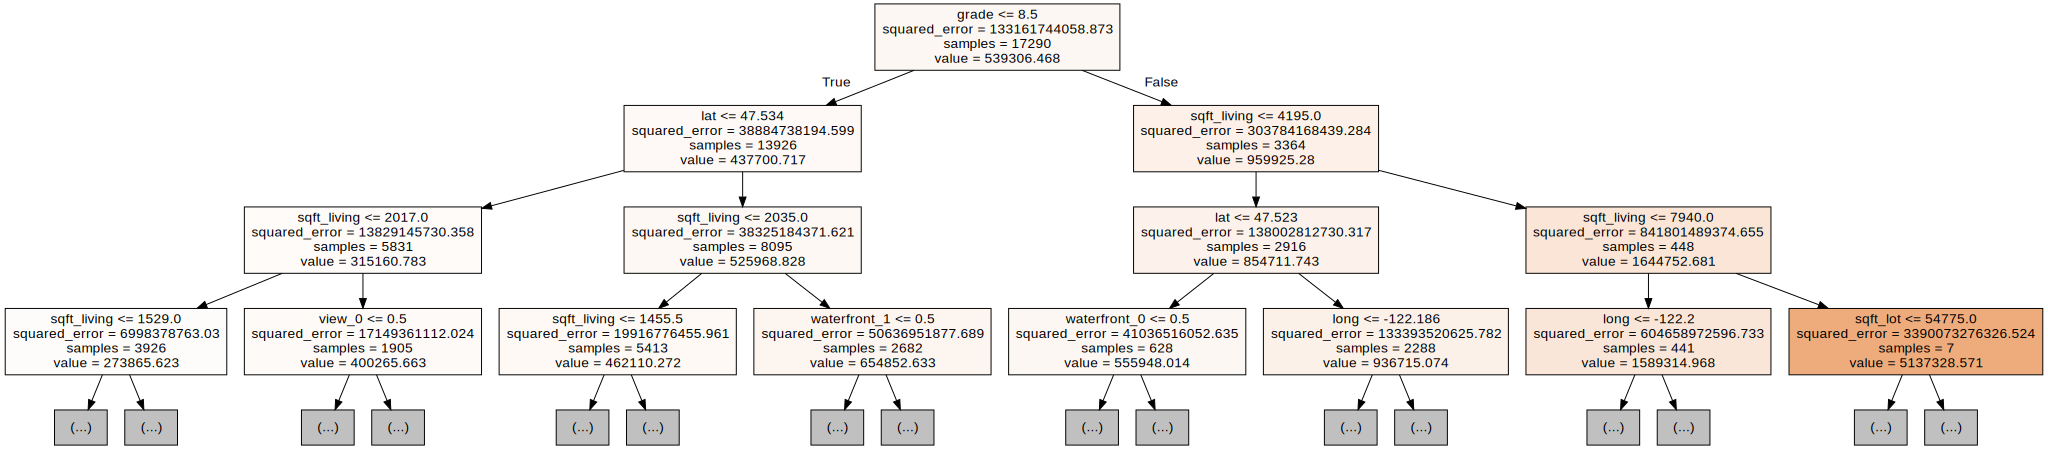

In [12]:
dot_data = export_graphviz(tree_model, filled=True, feature_names=X_train.columns, max_depth=3)
Source(dot_data, format='png')

In [13]:
## Overfitting!!!
print(tree_model.score(X_train, y_train))
print(tree_model.score(X_test, y_test))

0.9994392572882397
0.7524870641669075


In [14]:
## Buscando los "mejores" parámetros para Decision Tree
base_estimator_tree = DecisionTreeRegressor()
##
params = {'max_depth': [n+2 for n in range(9)],
          'criterion': ['squared_error','absolute_error',], 
          'min_samples_split' : [10 + 10*n for n in range(30)]}
###       
regressor_tree = RandomizedSearchCV(base_estimator_tree, params, cv=5, n_jobs=-1)
#search_tree = regressor_tree.fit(X_train, y_train)

In [15]:
#print(search_tree.best_params_)

In [16]:
## El "mejor" modelo.
tree_best = DecisionTreeRegressor(max_depth=9, criterion='squared_error', min_samples_split=70)
tree_best.fit(X_train, y_train)
print(f'R^2 en TRAIN: {tree_best.score(X_train, y_train):.4f}')
print(f'R^2 en TEST: {tree_best.score(X_test, y_test):.4f}')

R^2 en TRAIN: 0.8449
R^2 en TEST: 0.7945


### ***Modelo con RandomForestRegressor.***

In [17]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

RandomForestRegressor()

In [18]:
## Overfitting!!!
print(rf_model.score(X_train, y_train))
print(rf_model.score(X_test, y_test))

0.9823744593507524
0.8918564964981088


In [19]:
rf_model1 = RandomForestRegressor(max_depth=12, min_samples_split=50,
                                  n_estimators=100)
rf_model1.fit(X_train, y_train)
##
print(rf_model1.score(X_train, y_train))
print(rf_model1.score(X_test, y_test))

0.8948151418275074
0.8710871289125816


In [20]:
## Buscando los "mejores" parámetros para Random Forrest
## OJO NO CORRER DEMORA 53 MIN.
base_estimator_rf = RandomForestRegressor()
##
params = {'max_depth': [10, 12, 13, 14, 15], 
          'criterion': ['squared_error','absolute_error'], 
          'min_samples_split': [25 + 25*n for n in range(10)],
          'max_features': [9,10,50,90],
          'n_estimators': [100 + 50*n for n in range(5)]}
###       
regressor_rf = RandomizedSearchCV(base_estimator_rf, params, cv=5, n_jobs=-1)
#search_rf = regressor_rf.fit(X_train, y_train)

In [21]:
#print(search_rf.best_params_)

In [22]:
rf_model_best = RandomForestRegressor(n_estimators=200, max_depth=12, max_features=15,
                                      min_samples_split=50, )
rf_model_best.fit(X_train, y_train)
##
print(rf_model_best.score(X_train, y_train))
print(rf_model_best.score(X_test, y_test))

0.8588674790111025
0.8443598956919888


## ***Boosting. (Impulsar)***

Los modelos de ensemble son una herramienta estándar para el modelado predictivo. _Boosting_ es un técnica general para crear un conjunto de modelos. Como _bagging_, _boosting_ se usa más comúnmente con árboles de decisión. A pesar de sus similitudes, _boosting_ toma un enfoque muy diferente. Como resultado, mientras que el _bagging_ se puede hacer con relativamente poca afinación, _boosting_ requiere mucho mayor cuidado en su aplicación. Si estos dos métodos fueran coches, _bagging_ podría considerarse un Honda Accord (confiable y estable), mientras que _boosting_ podría ser
considerado un Porsche (potente pero requiere más cuidados). 

En los modelos de regresión lineal, los residuales se examinan para buscar mejorar el ajuste. _Boosting_ toma este concepto y va mucho más allá pues se ajusta a una serie de modelos, en los que cada modelo sucesivo
busca minimizar el error del modelo anterior. Varias variantes del algoritmo se usan comúnmente: _Adaboost_, _gradient boosting_  y _stocastic gradient boosting_. 



***Ideas importantes para Boosting.***

- ***Ensemble:*** Formar una predicción mediante el uso de una colección de modelos.

- ***Boosting:*** Una técnica general para ajustar una secuencia de modelos dando más peso a los registros con residuos grandes para cada ronda sucesiva.

- ***Adaboost:*** Una versión anterior de _boosting_ que vuelve a ponderar los datos en función de los residuos.

- ***Gradient Boosting:*** Una forma más general de ***Boosting*** que se lanza en términos de minimizar una función de costo.

- ***Stocastic gradient Boosting:*** El algoritmo más general para ***Boosting*** que incorpora remuestreo de registros y columnas en cada ronda.

- ***Regularización:*** Una técnica para evitar el _overfitting_  agregando un término de penalización a la función de coste en el número de parámetros en el modelo.

- ***Hiperparámetros:*** Parámetros que deben configurarse antes de ajustar el algoritmo.

## ***Algoritmo de Boosting.***

1. Inicialice $M$, el número máximo de modelos que se ajustarán, y configure el contador de la iteración con $m=1$. Inicializar los pesos de observación $w_i=\frac{1}{N}$ para $i = 1, 2, ..., N$. Inicializace el modelo de  _ensemble_ con  $\hat{F_0}= 0$.

2. Usando pesos para las instancias $w_1,w_2,...,w_{N}$, entre un modelo $\hat{f}_m$ entrene un modelo que ***minimice el error ponderado*** $e_m$, el cual es definido sumando los pesos de las instancias mal clasificadas.

3. Adicione a el modelo de _ensemble:_

$$\hat{F}_m=\hat{F}_{m-1}+\alpha_{m}\hat{f}_{m} \ \ \ \  \text{ donde $α_m=\frac{log(1-e_m)}{e_m}$}$$ 

4. Actualizar los pesos $w_1,w_2,..., w_N$ de modo que se aumentan los pesos para las instancias que fueron mal clasificadas. El tamaño del incremento depende de $α_m$, con valores más grandes de $α_m$ conducen a pesos más grandes.

5. Incrementar el contador del modelo $m=m+1$. Si $m≤M$ vaya al paso 2.

La estimación _Boosting_ viene dada por:

$$\hat{F} = α_1\hat{f}_1+ α_2\hat{f}_2 + ⋯ + α_M\hat{f}_{M}$$

Al aumentar los pesos de las observaciones que fueron mal clasificadas, el algoritmo obliga a los modelos a entrenar más intensamente en los datos para los que se desempeñó de manera deficiente. El factor $α_m$ asegura que los modelos con menor error tengan mayor peso. El aumento de gradiente es similar a Adaboost pero presenta el problema como una optimización de una función de coste. En lugar de ajustar los pesos, el _gradient Boosting_ ajusta los modelos a un _pseudo-residual_, que tiene el efecto de entrenar más intensamente en los residuos más grandes. En el espíritu del _Random Forrest_, _stocastic gradient boosting_ agrega aleatoriedad a el algoritmo mediante el muestreo de instancias y variables predictoras en cada etapa.

## ***XGBoost.***

XGBoost es una implemantación de _stocastic gradient boosting_.  El método xgboost tiene muchos parámetros que pueden y deben ajustarse. Dos parámetros muy importantes son:

- `subsample`: Controlan la fracción de observaciones que deben muestrearse en cada iteración.

- `learnig_rate`: Un factor de contracción aplicado a $α_m$ en el algoritmo _boosting_. El uso de submuestras hace que boosting actúe como _Random Forrest_, excepto que el muestreo se realiza sin reemplazo. El parámetro de contracción `learnig_rate` es útil para evitar el _overfitting_ al reducir el cambio en los pesos (un cambio menor en los pesos significa que el algoritmo es menos probable que en el set de train sufra de _overfitting_.

***Nota:***

En _xgboost_ los predictores deben ser convertido a una matriz de datos y la respuesta debe convertirse a variables 0/1. _xgboost_ elegirá una métrica para optimizar.
Por ejemplo, `eta` para a llamarse `learnig_rate` usar eta no fallará, pero no tendrá el efecto deseado:

### ***Regularización: Evitando el `overfitting`***

La aplicación "ciega" de _xgboost_ puede dar lugar a modelos inestables como resultado del overfitting en el set de train. El problema con el _overfitting_ es doble:

• El _accuracy_ del modelo en set nuevos se degradará.

• Las predicciones del modelo son muy variables, lo que genera resultados inestables.

Para la mayoría de las técnicas estadísticas, el _overfitting_ se puede evitar mediante un selección juiciosa de las variables predictoras. Incluso _Random Forrest_ generalmente produce un modelo razonable sin ajustar los parámetros. Este, sin embargo, no es el caso de _xgboost_. 

Ajustamos _xgboost_ a los datos de _loan data_ para el set de train con todas la varibles.



Hay dos parámetros en xgboost para regularizar el modelo: `reg_alpha` y `reg_lambda`, que corresponden a la distancia de Manhattan (L1-regularización) y euclidiana al cuadrado distancia (regularización L2), respectivamente. Aumentar estos parámetros penalizará modelos más complejos y reducirá el tamaño de los árboles qse forman. 

Otro enfoque es la regularización, una técnica que modifica la función de costo para penalizar la complejidad del modelo. Los árboles de decisión se ajustan al minimizar el criterio de costo. En _xgboost_, es posible modificar la función de costo agregando un término que mide la complejidad del modelo.

### ***Hiperparámetros de XGBoost.***

Los hiperparámetros para _xgboost_ se utilizan principalmente para equilibrar el _overfitting_ con el _accuracy_ y la complejidad computacional (es bueno consultar la documentación).


- `learnig_rate`: El factor de contracción entre 0 y 1 aplicado a $α$ en el algoritmo de _Boosting_. Para datos ruidosos, se recomiendan valores más pequeños.

- `n_estimadores`: El número de rondas de _Boosting_. Si `learning_rate` se establece en un valor pequeño, es importante aumente el número de rondas ya que el algoritmo aprende más lentamente. Mientras
se incluyen algunos parámetros para evitar el _overfitting_.

- `max_depth`: La profundidad máxima del árbol. En contraste con _Random Forrest_, que se adapta a árboles muy profundos, _boosting_ generalmente se adapta a árboles poco profundos. Esto tiene la ventaja de evitar interacciones complejas en el modelo que pueden surgir de datos ruidosos. El parámetro `max_ depth` es la profundidad máxima de un nodo hoja a la raíz del árbol con un valor. Esto nos da otra forma de controlar el _overfitting_: los árboles profundos tienden a ser más complejo y puede generar _overfitting_.

- `subsample y colsample_bytree`: Fracción de los registros a muestrear sin reemplazo y la fracción de predictores a muestrear para su usar en el ajuste de los árboles. Estos parámetros, que son similares a los de _Random Forrest_, ayudan a evitar el sobreajuste.

- `reg_lambda y reg_alfa`: Los parámetros de regularización para ayudar a controlar el _overfitting_




### ***Modelo con XGBoost***

In [23]:
xgb = xgboost.XGBRFRegressor(objective='reg:squarederror', 
                             max_depth=10, n_estimators=100, alpha=20)
xgb.fit(X_train, y_train)

XGBRFRegressor(alpha=20, max_depth=10, objective='reg:squarederror')

In [24]:
predict_train_xg = xgb.predict(X_train)
predict_test_xg = xgb.predict(X_test)
##
print(r2_score(y_train, predict_train_xg))
print(r2_score(y_test, predict_test_xg))

0.8791953841602476
0.8358580767267286


### ***Modelo con GradientBoosting.***

In [25]:
## Prepocesamiento de la Data.
df_GB = df.copy()
df_GB = df_GB.drop(columns=['id','sqft_living15','sqft_lot15','date'])
df_GB['renovated'] = df_GB['yr_renovated'] > 0
features_categoric = ['waterfront', 'zipcode', 'view']
for column in features_categoric:
    df_GB[column] = df_GB[column].astype('category')
X = df_GB.drop(columns=['price'])
y = df_GB['price']
##
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [26]:
columns = ['grade', 'sqft_above', 'waterfront', 'zipcode','view', 'lat', 'sqft_living']
gboost = GradientBoostingRegressor()
gboost.fit(X_train[columns], y_train)
print('R^2 en TRAIN =',gboost.score(X_train[columns], y_train))
print('R^2 en TEST=', gboost.score(X_test[columns], y_test))

R^2 en TRAIN = 0.8753561845138008
R^2 en TEST= 0.8723726270646501


In [27]:
## En "igualdad" de condiciones.
## Provienen de la regresión lineal de una lectura anteior.
columns = ['grade', 'sqft_above', 'waterfront', 'zipcode','view', 'lat', 'sqft_living']
gboost1 = GradientBoostingRegressor(learning_rate=0.0075, n_estimators=1000, max_depth=6,subsample=0.9,)
gboost1.fit(X_train[columns], y_train)
print(gboost1.score(X_train[columns], y_train))
print(gboost1.score(X_test[columns], y_test))

0.9334570173561303
0.8895153245779522


### ***Modelo LigthGBM***

In [28]:
lgbm = LGBMRegressor()
lgbm.fit(X_train, y_train)
print(lgbm.score(X_train, y_train))
print(lgbm.score(X_test, y_test))

0.9458668998132048
0.8930490857671513


In [29]:
## El MEJOR!!!
lgbm1 = LGBMRegressor(reg_alpha=2, min_child_samples=100, learning_rate=0.01,
                      n_estimators=500, objective='gamma')
lgbm1.fit(X_train, y_train)
print(lgbm1.score(X_train, y_train))
print(lgbm1.score(X_test, y_test))

0.878750451632866
0.8672567737919288


In [30]:
## En "igualdad" de condiciones.
## Provienen de la regresión lineal de una lectura anteior.
columns = ['grade', 'sqft_above', 'waterfront', 'zipcode','view', 'lat', 'sqft_living']
lgbm3 = LGBMRegressor(reg_alpha=2, min_child_samples=100,learning_rate=0.0075, reg_lamda=3,
                     n_estimators=1000, objective='gamma', max_depth=6,subsample=0.9)
lgbm3.fit(X_train, y_train)

LGBMRegressor(learning_rate=0.0075, max_depth=6, min_child_samples=100,
              n_estimators=1000, objective='gamma', reg_alpha=2, reg_lamda=3,
              subsample=0.9)

In [31]:
lgbm4 = LGBMRegressor(reg_alpha=2, min_child_samples=100,learning_rate=0.01,
                     n_estimators=500, objective='gamma', max_depth=6,subsample=0.9)
lgbm4.fit(X_train, y_train)
print(lgbm4.score(X_train, y_train))
print(lgbm.score(X_test, y_test))

0.8770346057460697
0.8930490857671513


In [32]:
lgbm = LGBMRegressor(reg_alpha=2, min_child_samples=100,learning_rate=0.0075, reg_lamda=3,
                     n_estimators=1000, objective='gamma', max_depth=6,subsample=0.9)
lgbm.fit(X_train, y_train)
print(lgbm4.score(X_train, y_train))
print(lgbm.score(X_test, y_test))

0.8770346057460697
0.8815652585025506
